In [1]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools 

In [2]:
class PolicyEvaluator:  ###PolicyEvaluator3
    def __init__(self, widths, goal, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T):
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy() #追加
        
    def init_policy(self): #追加
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return sum([self.goal.inside(np.array(c).T) for c in corners ]) == 4 #全部goal.insideがTrueならsumが4に

In [3]:
import seaborn as sns     ###policycheck

pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3)) 

<IPython.core.display.Javascript object>


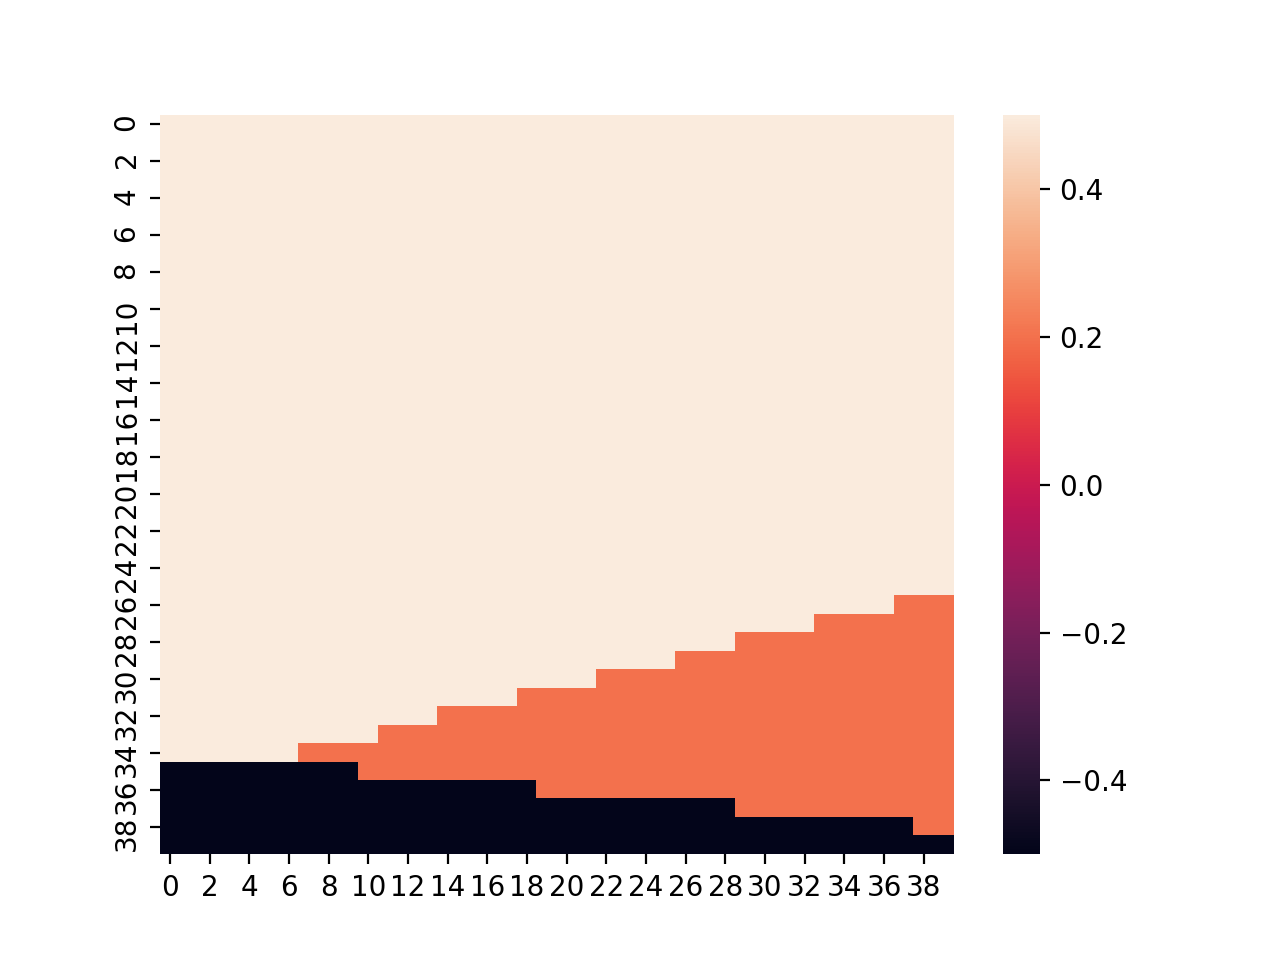

In [4]:
p = np.zeros(pe.index_nums)
for i in pe.indexes:
    p[i] = sum(pe.policy[i]) #速度と角速度を足すと、0.2: 直進、0.5: 左回転、-0.5: 右回転になる

sns.heatmap(np.rot90(p[:, :, 18]), square=False) #180〜190[deg]の向きのときの行動を図示
plt.show()